# Custom neural network combined with tensor train

Let's hacking `Pompon`!

One will use tensor train implementaion in `Pompon` and customized neural network build by [Flax](https://flax.readthedocs.io/en/latest/)

![](assets/pompon-flax.png)

Before start, install `Flax`.
In this example, we will follow [`flax.nnx`](https://flax-nnx.readthedocs.io/en/latest/) API rather than [`flax.linen`](https://flax-linen.readthedocs.io/en/latest/) API.

In [1]:
try:
    from flax import nnx
except ModuleNotFoundError:
    !uv pip install --quiet flax

## Import modules

In [2]:
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from tqdm.auto import tqdm

from pompon import DTYPE
from pompon._jittables import _forward_basis2y
from pompon.layers.tt import TensorTrain
from pompon.optimizer.sweeper import sweep

In [3]:
x_train = jnp.array(np.load('data/x_train.npy'))
y_train = jnp.array(np.load('data/y_train.npy'))
f_train = jnp.array(np.load('data/f_train.npy'))

x_valid = jnp.array(np.load('data/x_validation.npy'))
y_valid = jnp.array(np.load('data/y_validation.npy'))
f_valid = jnp.array(np.load('data/f_validation.npy'))

x_test = np.load('data/x_test.npy')
y_test = np.load('data/y_test.npy')
f_test = np.load('data/f_test.npy')

x_scale = x_train.std(axis=0)
print(x_scale)

[23.44059217 20.32924692 18.231819   14.57556216 11.2422871  11.1158607 ]


## Define Custom Network

### Define Basis function

Define network like this;

![](assets/nn-basis.png)

where $\phi_{\rho_i}(x_i): \mathbb{R}\to\mathbb{R}^d$ and $d$ is a number of basis (`chunk_size`).

In [4]:
class CustomBasis(nnx.Module):
    """
    Args:
        num_chunks (int): degree of freedoms n
        hidden_size (int): hidden layer size
        chunk_size (int): number of basis for each mode
        n_layers (int): number of hidden layers
        rngs (nnx.Rngs): random generator

    """

    def __init__(
        self,
        num_chunks: int,
        hidden_size: int,
        chunk_size: int,
        n_layers: int,
        x_scale: jax.Array,
        rngs: nnx.Rngs,
    ):
        self.num_chunks = num_chunks
        self.hidden_size = hidden_size
        self.chunk_size = chunk_size
        self.n_layers = n_layers
        self.x_scale = x_scale
        assert x_scale.shape == (num_chunks,)
        initializer = jax.nn.initializers.glorot_uniform()
        
        self.w_ini = nnx.Param(
            initializer(
                rngs.params(),
                (self.num_chunks, self.hidden_size),
                dtype=DTYPE,
            )
        )
        self.b_ini = nnx.Param(
            jnp.zeros((self.num_chunks, self.hidden_size), dtype=DTYPE)
        )

        self.w_mid = []
        self.b_mid = []
        for _ in range(n_layers):
            self.w_mid.append(
                nnx.Param(
                    initializer(
                        rngs.params(),
                        (self.hidden_size, self.hidden_size),
                        dtype=DTYPE,
                    )
                )
            )
            self.b_mid.append(
                nnx.Param(
                    jnp.zeros((self.num_chunks, self.hidden_size), dtype=DTYPE)
                )
            )
        self.w_fin = nnx.Param(
            initializer(
                rngs.params(),
                (self.hidden_size, self.chunk_size),
                dtype=DTYPE,
            )
        )
        self.b_fin = nnx.Param(
            jnp.zeros((self.num_chunks, self.chunk_size), dtype=DTYPE)
        )
        self.dropout = nnx.Dropout(0.9, rngs=rngs)

    def __call__(self, x: jax.Array, i: int | None = None) -> list[jax.Array]:
        r"""
        Args:
            x (jax.Array): input position with shape (batch_size, DOFs)
            i (int, optional): If you need only i-th basis $\phi_{\rho_i}$, 
                set this integer.

        Returns:
            list[jax.Array]: list of $\phi_{\rho_i}$ with length `num_chunks`.
                Each basis has shape `(chunk_size,)`.
        """
        if i is None:
            index: slice = slice(0, x.shape[1])
        else:
            index: slice = slice(i, i + 1)
            if x.ndim == 1:
                x = x[:, jnp.newaxis]  # batch, 1
            elif x.ndim == 2:
                assert x.shape[1] == 1
            else:
                raise ValueError(f"{x.ndim=} is invalid")
        ndim = x.shape[1]

        x = x / self.x_scale[jnp.newaxis, index]

        x = (
            self.w_ini[jnp.newaxis, index, :] * x[:, :, jnp.newaxis]
        )  # batch, num_chunks, hidden_size
        x = x + self.b_ini[jnp.newaxis, index, :]
        x = nnx.swish(x)

        for i in range(self.n_layers):
            res = x
            x = x @ self.w_mid[i]  # batch, num_chunks, hidden_size
            x = x + self.b_mid[i][jnp.newaxis, index, :]
            x = nnx.swish(x) + res

        x = x @ self.w_fin  # batch, num_chunks, chunk_size
        x = x + self.b_fin[jnp.newaxis, index, :]
        x = nnx.swish(x)
        #x = (1.0 - jnp.exp(-x))**2 # morse

        phi_chunked_array = jnp.split(x, ndim, axis=1)
        phi_chunked_list = [item.squeeze(1) for item in phi_chunked_array]

        return phi_chunked_list

### Define Custom Model including the Custom Basis

In [5]:
class CustomModel(nnx.Module):
    """
    Args:
        num_chunks (int): degree of freedoms n
        hidden_size (int): hidden layer size
        chunk_size (int): number of basis for each mode
        n_layers (int): number of hidden layers
        rngs (nnx.Rngs): random generator

    """

    def __init__(
        self,
        num_chunks: int,
        hidden_size: int,
        chunk_size: int,
        n_layers: int,
        x_scale: jax.Array,
        rngs: nnx.Rngs,
    ):
        self.num_chunks = num_chunks
        self.hidden_size = hidden_size
        self.chunk_size = chunk_size
        self.n_layers = n_layers

        self.basis = CustomBasis(
            num_chunks=self.num_chunks,
            hidden_size=self.hidden_size,
            chunk_size=self.chunk_size,
            n_layers=self.n_layers,
            x_scale=x_scale,
            rngs=rngs,
        )

    def __call__(self, x: jax.Array, W: list[jax.Array], norm: jax.Array):
        """
        Args:
            x (jax.Array): input position with shape (batch_size, DOFs)
            W (list[jax.Array]): list of tensor train core. 
                Each core has shape (bond_dim1, chunk_size, bond_dim2).
            norm (jax.Array): Scalar which scales outputs.
        """
        basis = self.basis(x)
        return _forward_basis2y(basis=basis, W=W, norm=norm)


model = CustomModel(
    num_chunks=6, hidden_size=16, chunk_size=8, n_layers=8, x_scale=x_scale, rngs=nnx.Rngs(0)
)
nnx.display(model)

CustomModel(
  num_chunks=6,
  hidden_size=16,
  chunk_size=8,
  n_layers=8,
  basis=CustomBasis(
    num_chunks=6,
    hidden_size=16,
    chunk_size=8,
    n_layers=8,
    x_scale=Array(shape=(6,), dtype=float64),
    w_ini=Param(
      value=Array(shape=(6, 16), dtype=float64)
    ),
    b_ini=Param(
      value=Array(shape=(6, 16), dtype=float64)
    ),
    w_mid=[Param(
      value=Array(shape=(16, 16), dtype=float64)
    ), Param(
      value=Array(shape=(16, 16), dtype=float64)
    ), Param(
      value=Array(shape=(16, 16), dtype=float64)
    ), Param(
      value=Array(shape=(16, 16), dtype=float64)
    ), Param(
      value=Array(shape=(16, 16), dtype=float64)
    ), Param(
      value=Array(shape=(16, 16), dtype=float64)
    ), Param(
      value=Array(shape=(16, 16), dtype=float64)
    ), Param(
      value=Array(shape=(16, 16), dtype=float64)
    )],
    b_mid=[Param(
      value=Array(shape=(6, 16), dtype=float64)
    ), Param(
      value=Array(shape=(6, 16), dtype=float

### Extract required arguments from TensorTrain modules

In [6]:
def get_norm_W(tt: TensorTrain) -> tuple[jax.Array, list[jax.Array]]:
    """
    Get norm & tt-cores.
    """
    W = [getattr(tt, f"W{i}").data for i in range(len(tt))]
    norm = tt.norm.data
    return norm, W

Initialize tensor train.

See also [pompon.layers.tt.TensorTrain](../reference/layers.tt.TensorTrain.qmd).

In [7]:
tt = TensorTrain.set_random(
    shape=(model.chunk_size,) * model.num_chunks, rank=4
)

## Train with energy

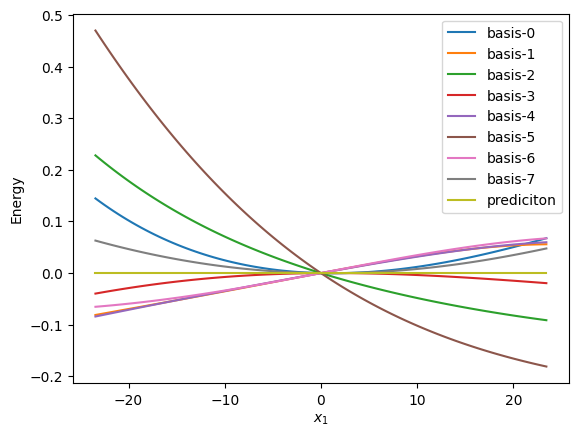

In [8]:
def show_basis(model, tt):
    x0 = np.linspace(-x_scale[0], x_scale[0], 100)
    x = np.zeros((100, model.num_chunks))
    x[:, 0] = x0
    basis = model.basis(jnp.array(x))
    for i in range(model.chunk_size):
        plt.plot(x0, np.array(basis[0][:, i]), label=f"basis-{i}")
    norm, W = get_norm_W(tt)
    y = model(jnp.array(x), W, norm)
    plt.plot(x0, np.array(y.squeeze(1)), label="prediciton")
    plt.legend()
    plt.xlabel("$x_1$")
    plt.ylabel("Energy")
    plt.show()

show_basis(model, tt)

### Show training trace

In [9]:
def show_trace(losses_train, losses_valid):
    plt.plot(losses_train, label='train')
    plt.plot(losses_valid, label='valid')
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
losses_train = []
losses_valid = []

### Train tensor train with fixed basis

See also [pompon.optimizer.sweeper.sweep](../reference/optimizer.sweeper.sweep.qmd).

In [10]:
sweep?

Signature:
sweep(
    *,
    tt: pompon.layers.tt.TensorTrain,
    basis: list[jax.Array],
    y: jax.Array,
    nsweeps: int = 2,
    maxdim: int | list[int] | numpy.ndarray = 30,
    cutoff: float | list[float] | numpy.ndarray = 0.01,
    optax_solver: optax._src.base.GradientTransformation | None = None,
    opt_maxiter: int = 1000,
    opt_tol: float | list[float] | numpy.ndarray | None = None,
    opt_lambda: float = 0.0,
    onedot: bool = False,
    use_CG: bool = False,
    use_scipy: bool = False,
    use_jax_scipy: bool = False,
    method: str = 'L-BFGS-B',
    ord: str = 'fro',
    auto_onedot: bool = True,
)
Docstring:
Tensor-train sweep optimization

Args:
    tt (TensorTrain): the tensor-train model.
    basis (list[Array]): the basis functions.
    y (Array): the target values.
    nsweeps (int): The number of sweeps.
    maxdim (int, list[int]): the maximum rank of TT-sweep.
    cutoff (float, list[float]): the ratio of truncated singular values for TT-sweep.
        W

## Train with forces

### Train basis with fixed tensor-train

Define function that returns $-\frac{\partial V}{\partial x}$ by auto differentiation

In [11]:
def get_force(x, model, norm, W):
    def func(x, model, norm, W):
        if x.ndim == 1:
            # When no-batch
            x = x[jnp.newaxis, :]
            return -1.0 * model(x, norm=norm, W=W).squeeze(0)
        else:
            return -1.0 * model(x, norm=norm, W=W)

    ener_fn = partial(func, model=model, norm=norm, W=W)
    jacobian = jax.vmap(jax.jacrev(ener_fn))(x)  # (batch, out, in)
    return jacobian.squeeze(-2)  # (batch, in)

Define train_step which has a loss function
$$
\mathcal{L} = \frac{1}{2|\mathcal{D}|} \sum_{\boldsymbol{x}, E, \boldsymbol{F} \in \mathcal{D}} \left[\left(\hat{V}(\boldsymbol{x})-V\right)^2 + \left(\hat{\mathbf{F}}(\boldsymbol{x})-\mathbf{F}\right)^2\right]
$$

In [12]:
def loss_fn(model, x, y, f, W, norm):
    pred = model(x, W, norm)
    loss = jnp.mean((pred - y) ** 2)
    pred_force = get_force(x, model, norm, W)
    loss += (
        jnp.sum((pred_force.flatten() - f.flatten()) ** 2)
        / pred_force.shape[0]
    )
    return loss

@nnx.jit
def train_step(model, optimizer, x, y, f, W, norm):
    loss, grads = nnx.value_and_grad(loss_fn)(model, x, y, f, W, norm)
    optimizer.update(grads)
    return loss

Sample force and energy

Check `train_step` works

In [13]:
norm, W = get_norm_W(tt)
tx = optax.adam(1e-3)
optimizer = nnx.Optimizer(model, tx)
loss = train_step(model, optimizer, x_train, y_train, f_train, W, norm)
loss

Array(0.18589966, dtype=float64)

### Train basis iteratively

### Train tensor train with fixed basis

Prepare basis gradient $-\frac{\partial \Phi}{\partial x_i}$

In [14]:
def get_partial_basis(x, i, model):
    assert x.ndim == 2  # batch, dim
    x = x[:, i : i + 1]

    def func(x, model):
        if x.ndim == 1:
            x = x[jnp.newaxis, :]
            return -1.0 * model.basis(x, i)[0].squeeze(0)
        else:
            return -1.0 * model.basis(x, i)[0]

    basis_fn = partial(func, model=model)
    # since in=1 < out=number of basis, we should use forward differentiation
    jacobian = jax.vmap(jax.jacfwd(basis_fn))(x)  # batch, out, in
    return jacobian.squeeze(2)  # batch, out

`partial_basis=`
$
\left[
-\frac{\partial \phi_{\rho_1}}{\partial x_1}, -\frac{\partial \phi_{\rho_2}}{\partial x_2}, \cdots, -\frac{\partial \phi_{\rho_n}}{\partial x_n}
\right]
$

In [15]:
partial_basis = [
    get_partial_basis(x_train, i, model) for i in range(x_train.shape[1])
]

`basis=`
$\left[\phi_{\rho_1}, \phi_{\rho_2}, \cdots, \phi_{\rho_n} \right]$

In [16]:
basis = model.basis(x_train)

`concat_y=`$y_p$
where $p=k \otimes i$
$$
y_p = y_i^{(k)} = 
\begin{cases}
\boldsymbol{F}_i^{(k)} & \mathrm{for} \quad i \leq n \\
E^{(k)} & \mathrm{for} \quad i = n+1
\end{cases}
$$

In [17]:
concat_y = jnp.vstack(
    [f_train[:, i : i + 1] for i in range(len(basis))] + [y_train]
)
print(concat_y.shape)

(4375, 1)


`basis_list=`
$$
\begin{bmatrix}
[\partial_{x_1}\phi_{\rho_1} & \phi_{\rho_2} & \cdots & \phi_{\rho_n} ], \\
[\phi_{\rho_1} & \partial_{x_2}\phi_{\rho_2} & \cdots & \phi_{\rho_n} ], \\
& & \vdots & & \\
[\phi_{\rho_1} & \phi_{\rho_2} & \cdots & \partial_{x_n}\phi_{\rho_n} ], \\
[\phi_{\rho_1} & \phi_{\rho_2} & \cdots & \phi_{\rho_n} ]
\end{bmatrix}
$$


`concat_basis=`
$
\left[\varphi_{\rho_1}, \varphi_{\rho_2}, \cdots, \varphi_{\rho_n}\right]
$
where
$$
\varphi_{\rho_j}^p = \varphi_{i, \rho_i}^{(k)} = 
\begin{cases}
-\partial_{x_j}\phi_{\rho_j} & \mathrm{for} \quad i=j \\
\phi_{\rho_j} & \mathrm{otherwise}
\end{cases}
$$

In [18]:
def get_concat_basis(x: jax.Array, model: CustomModel) -> list[jax.Array]:
    """
    Args:
        x (jax.Array): postions
        model (CustomModel): model

    Returns:
        list[jax.Array]: derivative concatenated basis
    """
    partial_basis = [get_partial_basis(x, i, model) for i in range(x.shape[1])]
    basis = model.basis(x)
    basis_list = []
    for i in range(len(basis)):
        basis_row = [
            ϕ.copy() if k != i else dϕ.copy()
            for k, (ϕ, dϕ) in enumerate(zip(basis, partial_basis, strict=True))
        ]
        basis_list.append(basis_row)
    basis_list.append(basis)
    concat_basis = [
        jnp.vstack([φ[i] for φ in basis_list]) for i in range(len(basis))
    ]
    return concat_basis


concat_basis = get_concat_basis(x_train, model)
print(concat_basis[0].shape)

(4375, 8)


### Train tensor train with fixed basis

Only `basis` & `y` are changed from energy optimization.

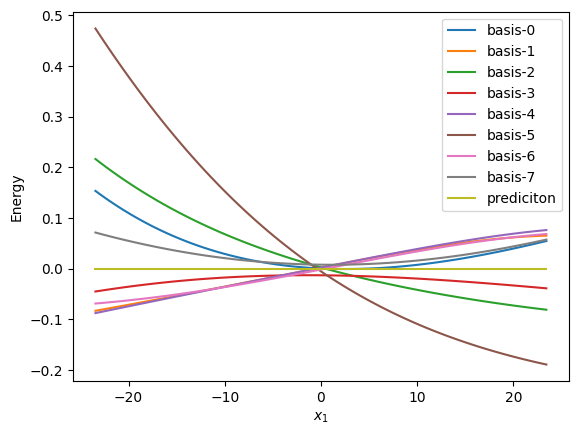

In [19]:
show_basis(model, tt)

### Repeat tensor train optimization & basis optimization

In [20]:
tx = optax.adam(1e-3)
optimizer = nnx.Optimizer(model, tx)
progress_bar = tqdm(range(1500))
for i in progress_bar:
    if i % 100 == 0:
        norm, W = get_norm_W(tt)
        concat_basis = get_concat_basis(x_train, model)
        sweep(
            tt=tt,
            basis=concat_basis,
            y=concat_y,
            nsweeps=1,
            maxdim=4,
            opt_maxiter=100,
            cutoff=1.e-03,
            optax_solver=optax.adam(1.e-03),
            #use_CG=True,
            onedot=True,
            auto_onedot=False,
        )
        norm, W = get_norm_W(tt)
    loss_train = train_step(
        model, optimizer, x_train, y_train, f_train, W, norm
    )
    loss_valid = loss_fn(
        model, x_valid, y_valid, f_valid, W, norm
    )
    losses_train.append(loss_train)
    losses_valid.append(loss_valid)
    progress_bar.set_postfix({"train": f"{losses_train[-1]:.2e}", "valid":f"{losses_valid[-1]:.2e}", "ranks": f"{tt.ranks}"})

  0%|          | 0/1500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

2024-10-08 19:00:22 - INFO:pompon.optimizer - BEGIN TT-sweep 1/1
2024-10-08 19:00:22 - INFO:pompon.optimizer - Maxdim=4, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=100
2024-10-08 19:00:22 - INFO:pompon.optimizer - DONE TT-sweep 1/1


0it [00:00, ?it/s]

2024-10-08 19:00:27 - INFO:pompon.optimizer - BEGIN TT-sweep 1/1
2024-10-08 19:00:27 - INFO:pompon.optimizer - Maxdim=4, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=100
2024-10-08 19:00:27 - INFO:pompon.optimizer - DONE TT-sweep 1/1


0it [00:00, ?it/s]

2024-10-08 19:00:30 - INFO:pompon.optimizer - BEGIN TT-sweep 1/1
2024-10-08 19:00:30 - INFO:pompon.optimizer - Maxdim=4, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=100
2024-10-08 19:00:31 - INFO:pompon.optimizer - DONE TT-sweep 1/1


0it [00:00, ?it/s]

2024-10-08 19:00:35 - INFO:pompon.optimizer - BEGIN TT-sweep 1/1
2024-10-08 19:00:35 - INFO:pompon.optimizer - Maxdim=4, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=100
2024-10-08 19:00:35 - INFO:pompon.optimizer - DONE TT-sweep 1/1


0it [00:00, ?it/s]

2024-10-08 19:00:38 - INFO:pompon.optimizer - BEGIN TT-sweep 1/1
2024-10-08 19:00:38 - INFO:pompon.optimizer - Maxdim=4, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=100
2024-10-08 19:00:39 - INFO:pompon.optimizer - DONE TT-sweep 1/1


0it [00:00, ?it/s]

2024-10-08 19:00:42 - INFO:pompon.optimizer - BEGIN TT-sweep 1/1
2024-10-08 19:00:42 - INFO:pompon.optimizer - Maxdim=4, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=100
2024-10-08 19:00:43 - INFO:pompon.optimizer - DONE TT-sweep 1/1


0it [00:00, ?it/s]

2024-10-08 19:00:46 - INFO:pompon.optimizer - BEGIN TT-sweep 1/1
2024-10-08 19:00:46 - INFO:pompon.optimizer - Maxdim=4, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=100
2024-10-08 19:00:47 - INFO:pompon.optimizer - DONE TT-sweep 1/1


0it [00:00, ?it/s]

2024-10-08 19:00:50 - INFO:pompon.optimizer - BEGIN TT-sweep 1/1
2024-10-08 19:00:50 - INFO:pompon.optimizer - Maxdim=4, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=100
2024-10-08 19:00:51 - INFO:pompon.optimizer - DONE TT-sweep 1/1


0it [00:00, ?it/s]

2024-10-08 19:00:54 - INFO:pompon.optimizer - BEGIN TT-sweep 1/1
2024-10-08 19:00:54 - INFO:pompon.optimizer - Maxdim=4, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=100
2024-10-08 19:00:54 - INFO:pompon.optimizer - DONE TT-sweep 1/1


0it [00:00, ?it/s]

2024-10-08 19:00:58 - INFO:pompon.optimizer - BEGIN TT-sweep 1/1
2024-10-08 19:00:58 - INFO:pompon.optimizer - Maxdim=4, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=100
2024-10-08 19:00:59 - INFO:pompon.optimizer - DONE TT-sweep 1/1


0it [00:00, ?it/s]

2024-10-08 19:01:02 - INFO:pompon.optimizer - BEGIN TT-sweep 1/1
2024-10-08 19:01:02 - INFO:pompon.optimizer - Maxdim=4, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=100
2024-10-08 19:01:03 - INFO:pompon.optimizer - DONE TT-sweep 1/1


0it [00:00, ?it/s]

2024-10-08 19:01:06 - INFO:pompon.optimizer - BEGIN TT-sweep 1/1
2024-10-08 19:01:06 - INFO:pompon.optimizer - Maxdim=4, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=100
2024-10-08 19:01:07 - INFO:pompon.optimizer - DONE TT-sweep 1/1


0it [00:00, ?it/s]

2024-10-08 19:01:10 - INFO:pompon.optimizer - BEGIN TT-sweep 1/1
2024-10-08 19:01:10 - INFO:pompon.optimizer - Maxdim=4, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=100
2024-10-08 19:01:11 - INFO:pompon.optimizer - DONE TT-sweep 1/1


0it [00:00, ?it/s]

2024-10-08 19:01:14 - INFO:pompon.optimizer - BEGIN TT-sweep 1/1
2024-10-08 19:01:14 - INFO:pompon.optimizer - Maxdim=4, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=100
2024-10-08 19:01:15 - INFO:pompon.optimizer - DONE TT-sweep 1/1


0it [00:00, ?it/s]

2024-10-08 19:01:18 - INFO:pompon.optimizer - BEGIN TT-sweep 1/1
2024-10-08 19:01:18 - INFO:pompon.optimizer - Maxdim=4, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=100
2024-10-08 19:01:19 - INFO:pompon.optimizer - DONE TT-sweep 1/1


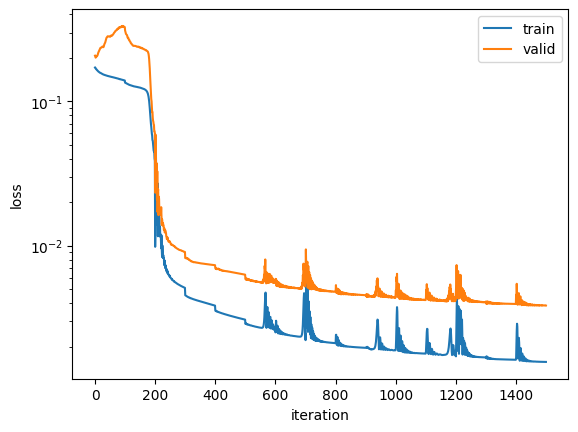

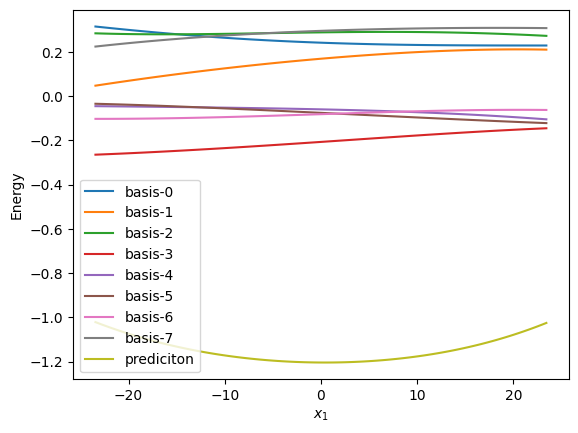

In [21]:
show_trace(losses_train, losses_valid)
show_basis(model, tt)

In [22]:
tx = optax.adam(1e-3)
optimizer = nnx.Optimizer(model, tx)
progress_bar = tqdm(range(1500))
for i in progress_bar:
    if i % 150 == 0:
        norm, W = get_norm_W(tt)
        concat_basis = get_concat_basis(x_train, model)
        sweep(
            tt=tt,
            basis=concat_basis,
            y=concat_y,
            nsweeps=3,
            maxdim=8,
            opt_maxiter=150,
            cutoff=1.e-02,
            optax_solver=optax.adam(1.e-03),
            #use_CG=True,
            onedot=False,
        )
        norm, W = get_norm_W(tt)
    loss_train = train_step(
        model, optimizer, x_train, y_train, f_train, W, norm
    )
    loss_valid = loss_fn(
        model, x_valid, y_valid, f_valid, W, norm
    )
    losses_train.append(loss_train)
    losses_valid.append(loss_valid)
    progress_bar.set_postfix({"train": f"{losses_train[-1]:.2e}", "valid":f"{losses_valid[-1]:.2e}", "ranks": f"{tt.ranks}"})

  0%|          | 0/1500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

2024-10-08 19:01:23 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:01:23 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:23 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:01:23 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:01:23 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:23 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:01:24 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:01:24 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:01:24 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:24 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:01:31 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:01:31 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:31 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:01:31 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:01:31 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:01:31 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:31 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:01:31 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:01:31 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:31 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:01:37 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:01:37 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:37 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:01:38 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:01:38 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:01:38 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:38 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:01:38 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:01:38 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:38 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:01:44 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:01:44 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:44 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:01:45 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:01:45 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:01:45 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:45 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:01:45 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:01:45 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:45 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:01:51 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:01:51 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:51 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:01:52 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:01:52 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:01:52 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:52 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:01:52 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:01:52 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:52 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:01:58 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:01:58 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:58 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:01:59 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:01:59 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:01:59 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:59 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:01:59 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:01:59 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:01:59 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:02:05 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:02:05 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:02:05 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:02:06 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:02:06 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:02:06 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:02:06 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:02:06 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:02:06 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:02:06 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:02:12 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:02:12 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:02:12 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:02:13 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:02:13 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:02:13 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:02:13 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:02:13 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:02:13 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:02:13 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:02:19 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:02:19 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:02:19 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:02:20 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:02:20 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:02:20 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:02:20 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:02:20 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:02:20 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:02:20 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:02:27 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:02:27 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:02:27 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:02:27 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:02:27 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:02:27 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:02:27 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:02:27 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:02:27 - INFO:pompon.optimizer - Maxdim=8, Cutoff=1.00e-02, Opt_tol=1.00e-02, Opt_maxiter=150
2024-10-08 19:02:27 - INFO:pompon.optimizer - DONE TT-sweep 3/3


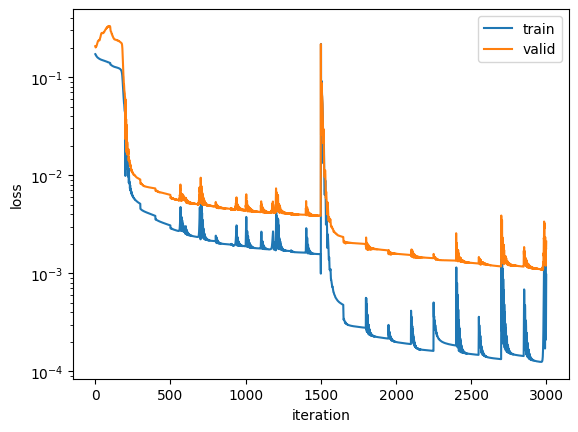

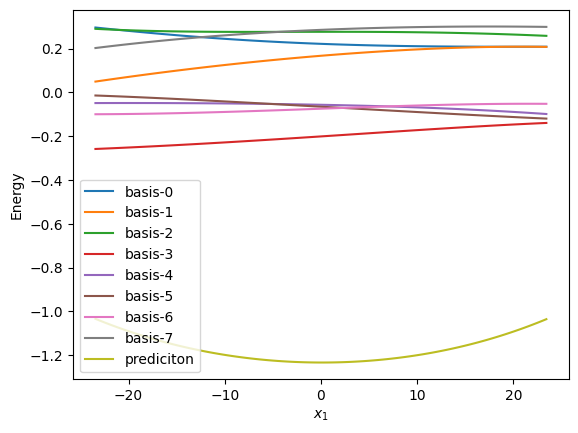

In [23]:
show_trace(losses_train, losses_valid)
show_basis(model, tt)

In [24]:
tx = optax.adam(1e-4)
optimizer = nnx.Optimizer(model, tx)
progress_bar = tqdm(range(1500))
for i in progress_bar:
    if i % 150 == 0:
        norm, W = get_norm_W(tt)
        concat_basis = get_concat_basis(x_train, model)
        sweep(
            tt=tt,
            basis=concat_basis,
            y=concat_y,
            nsweeps=3,
            maxdim=12,
            opt_maxiter=150,
            cutoff=1.e-03,
            optax_solver=optax.adam(1.e-04),
            onedot=False,
        )
        norm, W = get_norm_W(tt)
    loss_train = train_step(
        model, optimizer, x_train, y_train, f_train, W, norm
    )
    loss_valid = loss_fn(
        model, x_valid, y_valid, f_valid, W, norm
    )
    losses_train.append(loss_train)
    losses_valid.append(loss_valid)
    progress_bar.set_postfix({"train": f"{losses_train[-1]:.2e}", "valid":f"{losses_valid[-1]:.2e}", "ranks": f"{tt.ranks}"})

  0%|          | 0/1500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

2024-10-08 19:02:34 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:02:34 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:02:35 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:02:35 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:02:35 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:02:35 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:02:36 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:02:36 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:02:36 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:02:36 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:02:43 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:02:43 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:02:43 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:02:43 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:02:43 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:02:43 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:02:44 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:02:44 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:02:44 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:02:44 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:02:50 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:02:50 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:02:50 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:02:51 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:02:51 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:02:51 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:02:51 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:02:51 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:02:51 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:02:51 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:02:58 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:02:58 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:02:58 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:02:58 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:02:58 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:02:58 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:02:58 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:02:58 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:02:58 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:02:59 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:03:05 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:03:05 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:05 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:03:05 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:03:05 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:03:05 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:06 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:03:06 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:03:06 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:06 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:03:12 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:03:12 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:12 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:03:13 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:03:13 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:03:13 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:13 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:03:13 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:03:13 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:13 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:03:20 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:03:20 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:20 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:03:20 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:03:20 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:03:20 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:21 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:03:21 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:03:21 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:21 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:03:27 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:03:27 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:27 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:03:28 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:03:28 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:03:28 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:28 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:03:28 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:03:28 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:28 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:03:35 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:03:35 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:35 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:03:36 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:03:36 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:03:36 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:36 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:03:36 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:03:36 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:36 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:03:43 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:03:43 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:43 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:03:43 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:03:43 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:03:43 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:43 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:03:43 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:03:43 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:44 - INFO:pompon.optimizer - DONE TT-sweep 3/3


In [25]:
tx = optax.adam(1e-5)
optimizer = nnx.Optimizer(model, tx)
progress_bar = tqdm(range(1500))
for i in progress_bar:
    if i % 150 == 0:
        norm, W = get_norm_W(tt)
        concat_basis = get_concat_basis(x_train, model)
        sweep(
            tt=tt,
            basis=concat_basis,
            y=concat_y,
            nsweeps=3,
            maxdim=12,
            opt_maxiter=150,
            cutoff=1.e-03,
            optax_solver=optax.adam(1.e-05),
            onedot=False,
        )
        norm, W = get_norm_W(tt)
    loss_train = train_step(
        model, optimizer, x_train, y_train, f_train, W, norm
    )
    loss_valid = loss_fn(
        model, x_valid, y_valid, f_valid, W, norm
    )
    losses_train.append(loss_train)
    losses_valid.append(loss_valid)
    progress_bar.set_postfix({"train": f"{losses_train[-1]:.2e}", "valid":f"{losses_valid[-1]:.2e}", "ranks": f"{tt.ranks}"})

  0%|          | 0/1500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

2024-10-08 19:03:50 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:03:50 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:50 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:03:51 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:03:51 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:03:51 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:51 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:03:51 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:03:51 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:51 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:03:59 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:03:59 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:59 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:03:59 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:03:59 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:03:59 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:59 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:03:59 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:03:59 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:03:59 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:04:06 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:04:06 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:06 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:04:06 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:04:06 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:04:06 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:06 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:04:06 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:04:06 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:07 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:04:13 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:04:13 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:13 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:04:13 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:04:13 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:04:13 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:13 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:04:13 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:04:13 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:14 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:04:20 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:04:20 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:20 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:04:20 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:04:20 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:04:20 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:21 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:04:21 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:04:21 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:21 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:04:27 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:04:27 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:27 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:04:27 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:04:27 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:04:27 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:28 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:04:28 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:04:28 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:28 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:04:34 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:04:34 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:34 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:04:34 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:04:34 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:04:34 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:35 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:04:35 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:04:35 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:35 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:04:42 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:04:42 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:42 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:04:42 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:04:42 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:04:42 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:42 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:04:42 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:04:42 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:42 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:04:49 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:04:49 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:49 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:04:49 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:04:49 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:04:49 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:49 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:04:49 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:04:49 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:50 - INFO:pompon.optimizer - DONE TT-sweep 3/3


0it [00:00, ?it/s]

2024-10-08 19:04:56 - INFO:pompon.optimizer - BEGIN TT-sweep 1/3
2024-10-08 19:04:56 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:56 - INFO:pompon.optimizer - Maxdim is reached. Switch to one-dot core optimization
2024-10-08 19:04:56 - INFO:pompon.optimizer - DONE TT-sweep 1/3
2024-10-08 19:04:56 - INFO:pompon.optimizer - BEGIN TT-sweep 2/3
2024-10-08 19:04:56 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:57 - INFO:pompon.optimizer - DONE TT-sweep 2/3
2024-10-08 19:04:57 - INFO:pompon.optimizer - BEGIN TT-sweep 3/3
2024-10-08 19:04:57 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-03, Opt_tol=1.00e-03, Opt_maxiter=150
2024-10-08 19:04:57 - INFO:pompon.optimizer - DONE TT-sweep 3/3


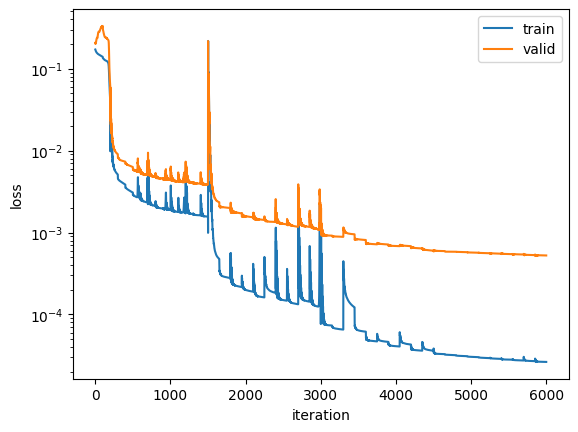

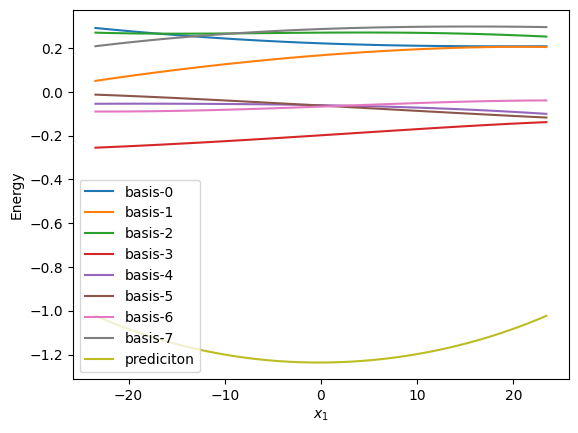

In [26]:
show_trace(losses_train, losses_valid)
show_basis(model, tt)

In [27]:
concat_basis = get_concat_basis(x_train, model)
sweep(
            tt=tt,
            basis=concat_basis,
            y=concat_y,
            nsweeps=50,
            opt_tol=1.e-12,
            maxdim=12,
            opt_maxiter=100000,
            use_CG=True,
            onedot=True,
)
tx = optax.adam(0.0)
optimizer = nnx.Optimizer(model, tx)
norm, W = get_norm_W(tt)
loss_train = train_step(
        model, optimizer, x_train, y_train, f_train, W, norm
)
loss_valid = loss_fn(
        model, x_valid, y_valid, f_valid, W, norm
    )
losses_train.append(loss_train)
losses_valid.append(loss_valid)

0it [00:00, ?it/s]

2024-10-08 19:05:04 - INFO:pompon.optimizer - BEGIN TT-sweep 1/50
2024-10-08 19:05:04 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-02, Opt_tol=1.00e-12, Opt_maxiter=100000
2024-10-08 19:05:07 - INFO:pompon.optimizer - DONE TT-sweep 1/50
2024-10-08 19:05:07 - INFO:pompon.optimizer - BEGIN TT-sweep 2/50
2024-10-08 19:05:07 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-02, Opt_tol=1.00e-12, Opt_maxiter=100000
2024-10-08 19:05:09 - INFO:pompon.optimizer - DONE TT-sweep 2/50
2024-10-08 19:05:09 - INFO:pompon.optimizer - BEGIN TT-sweep 3/50
2024-10-08 19:05:09 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-02, Opt_tol=1.00e-12, Opt_maxiter=100000
2024-10-08 19:05:12 - INFO:pompon.optimizer - DONE TT-sweep 3/50
2024-10-08 19:05:12 - INFO:pompon.optimizer - BEGIN TT-sweep 4/50
2024-10-08 19:05:12 - INFO:pompon.optimizer - Maxdim=12, Cutoff=1.00e-02, Opt_tol=1.00e-12, Opt_maxiter=100000
2024-10-08 19:05:14 - INFO:pompon.optimizer - DONE TT-sweep 4/50
2024-10-08 19:05:14 - INFO:pompo

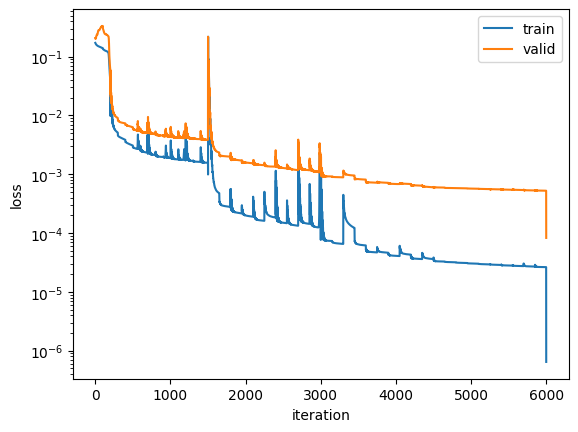

In [28]:
show_trace(losses_train, losses_valid)

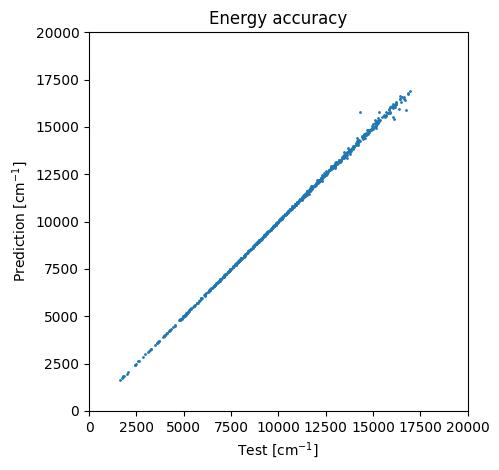

In [29]:
y_shift = -3112.1604302407663  # eV (mean)
y_min = -3113.4044750979383  # eV (eq. position)

fig, ax = plt.subplots(dpi=100)
y_pred = model(jnp.array(x_test), W, norm)

ax.scatter(
    (y_test + y_shift - y_min) * 8.065544e3,
    (y_pred + y_shift - y_min) * 8.065544e3,
    s=1,
)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("Test [cm$^{-1}$]")
plt.ylabel("Prediction [cm$^{-1}$]")
plt.xlim(0, 20000)
plt.ylim(0, 20000)
plt.title("Energy accuracy")
plt.tight_layout()
plt.show()

In [30]:
np.mean(np.abs(y_test - y_pred)) * 8.065544e3

np.float64(33.0846775538686)